In [1]:
# Will Hollingsworth, Colton Murray, Alexander Shiveley

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Getting the data into Python

In [3]:
# Load the csv as a numpy array of strings, 
# because it includes the column headers
raw_data = np.loadtxt('data_banknote_authentication.txt', delimiter=',', dtype=str)

# Convert everything into floats!
clean_data = np.array(raw_data, dtype=float)

clean_data

array([[  3.6216 ,   8.6661 ,  -2.8073 ,  -0.44699,   0.     ],
       [  4.5459 ,   8.1674 ,  -2.4586 ,  -1.4621 ,   0.     ],
       [  3.866  ,  -2.6383 ,   1.9242 ,   0.10645,   0.     ],
       ...,
       [ -3.7503 , -13.4586 ,  17.5932 ,  -2.7771 ,   1.     ],
       [ -3.5637 ,  -8.3827 ,  12.393  ,  -1.2823 ,   1.     ],
       [ -2.5419 ,  -0.65804,   2.6842 ,   1.1952 ,   1.     ]])

In [4]:
def get_sets(data, split):
    """
    Convenience function that randomly selects a training and test set from the input data.
    
    :param data: (ndarray) the data you want to split
    :param split: (float array) the percentages of the data you want to be TRAINING, VALIDATION, and TESTING data
    
    :returns: (tuple) a tuple where the first element is the training set, and the second element is the test set
    """
    # Randomly shuffle the order from a copy of the data
    shuffled = data.copy()
    np.random.shuffle(shuffled)

    row_count = data.shape[0]

    # calc the number of samples, assumes the input samples are seperated by row
    training_count = round(row_count * split[0])
    
    training_set = shuffled[:training_count]
    remaining_set = shuffled[training_count:]
    
    # calc the number of samples, assumes the input samples are seperated by row
    training_count = round(row_count * split[1] / (split[1] + split[2]))
    
    validation_set = remaining_set[:training_count]
    test_set = remaining_set[training_count:]
    
    return training_set, validation_set, test_set

In [5]:
training, validation, test = get_sets(clean_data, [1/3, 1/3, 1/3])

# Perceptron (2 Input Linear Unit)

In [6]:
class linear_unit():
    def __init__(self, num_inputs):
        self.weights = np.random.rand(num_inputs + 1)
        
    def output(self, data_point):
        """
        Returns the linear combination of the input and this unit's weights
        """
        # total = w0*1 + w1x1 + w2x2 + ...
        data_with_bias = np.hstack((np.array([1]), data_point[:-1]))
        t = data_with_bias * self.weights
        t = np.sum(t)
        
        return t     

## Neural Network

In [7]:
class neural_net():
    def __init__(self, num_inputs, num_hidden, num_outputs, squash_f, squash_d_f):
        self.hidden_units = []
        for _ in range(num_hidden):
            self.hidden_units.append(linear_unit(num_inputs))
        self.output_units = []
        for _ in range(num_outputs):
            self.output_units.append(linear_unit(num_hidden))
        self.squash_fn = squash_f
        self.squash_d_fn = squash_d_f    
        
    def output(self, data_point):
        """
        Returns the array of outputs from the output units
        """            
        
        return self.output_at_layer(data_point, 1)
    
    def output_data_set(self, data_set, normalizer=None):
        """
        Returns the array of outputs from the output units for an entire data set
        normalize - Set output to 0 or 1
        """            
        y_matrix = np.empty((data_set.shape[0], 1))
        for row in range(data_set.shape[0]):
            y_matrix[row, 0] = self.output(data_set[row, :])
            if normalizer is not None:
                y_matrix[row, 0] = normalizer(y_matrix[row, 0])
        return y_matrix
    
    def output_at_layer(self, data_point, layer):
        
        """
        Returns the array of outputs from the units on the specified layer
        0 - hidden
        1 - output
        """
        ## Calculate squashed hidden outputs, with bias
        hidden_out = [1]
        for unit in self.hidden_units:
            hidden_out.append(self.squash_fn(unit.output(data_point)))
        
        if layer == 0:
            return np.array(hidden_out)
            
        ## Calculate squashed outputs using hidden outputs
        out = []
        for unit in self.output_units:
            out.append(self.squash_fn(unit.output(hidden_out)))    
            
        return np.array(out)
        
        
    def error(self, data):
        """
        Returns the sum squared error of the data using this network's output units
        """
        sum = 0
        for d in data:
            # Only 1 output is handled is supported
            o = self.output(d)[0]
            sum = sum + (d[2] - o)**2
        return sum

## Squashing Functions

In [44]:
# Sigmoid function
def sigmoid(x):    
    return 1 / (1 + np.exp(-x))

# Sigmoid derivative function
def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Hyperbolic tan function
def tanh(x):
    return np.tanh(x)

# Hyperbolic tan derivative function
def tanh_d(x):
    return 1 - tanh(x)**2

In [9]:
net = neural_net(4, 4, 1, sigmoid, sigmoid_d)
print(training[0])
print(net.output(training[0]))
print(net.error(training))

[3.6667  4.302   0.55923 0.33791 0.     ]
[0.92950775]
7825.364803995308


## Backpropagation

In [10]:
def backpropagation(squash_f, squash_d_f, learning_rate, epochs, hidden_count):    
    """
    Train the network with the specified number of hidden units using backpropagation
    """
    # Step 1 Initialize network
    network = neural_net(4, hidden_count, 1, squash_f, squash_d_f)
    
    # From NN-MitchelChapter4-2 on canvas
    # Alex - Started on it but need to be careful with tanh. The notes on canvas works out sigmoid in detail but not tanh
    #           Using a more generalized form of the equations for the algorithm in 1.2

    for epoch in range(epochs):
        for d in training:
            d_with_bias = np.hstack((np.array([1]), d[:-1]))
            hidden_out = network.output_at_layer(d, 0)

            # Step 2 but relacing specific sigmoid derivative with the squash derivative
            delta_out = []
            for k in range(len(network.output_units)):
                unit = network.output_units[k]
                unit_out = unit.output(hidden_out)
                unit_delta = squash_d_f(unit_out) * (d[4] - squash_f(unit_out))
                delta_out.append(unit_delta)

            # Step 3 but replacing specific sigmoid derivative with the squash derivative
            delta_hidden = []
            for h in range(len(network.hidden_units)):
                unit = network.hidden_units[h]
                unit_out = unit.output(d_with_bias)
                sum_value = np.sum([network.output_units[k].weights[1 + h] * delta_out[k] for k in range(len(network.output_units))])
                unit_delta = squash_d_f(unit_out) * sum_value
                delta_hidden.append(unit_delta)

            # Step 4 update weights
            for k in range(len(network.output_units)):
                delta_w = learning_rate * delta_out[k] * hidden_out
                network.output_units[k].weights = network.output_units[k].weights + delta_w

            for h in range(len(network.hidden_units)):
                delta_w = learning_rate * delta_hidden[h] * d_with_bias
                network.hidden_units[h].weights = network.hidden_units[h].weights + delta_w
                
            
    return network

## Sigmoid Best Network

In [32]:
sigmoid_networks = []
sigmoid_best_network = None
for h in range(1, 5):
    net = backpropagation(sigmoid, sigmoid_d, 0.01, 100, h)
    sigmoid_networks.append(net)
    
    # If this network has lower error from validation set, set as best
    if sigmoid_best_network is None or net.error(validation) < sigmoid_best_network.error(validation):
        sigmoid_best_network = net
    
    print("Hidden Layer Size:", len(net.hidden_units))
    print("Validation Error:", net.error(validation))
    print("Test Error:", net.error(test))
    print()

print("Best Network Hidden Layer Size Based on Validation Error:", len(sigmoid_best_network.hidden_units))

Hidden Layer Size: 1
Validation Error: 14337.419475930441
Test Error: 4482.170031842186

Hidden Layer Size: 2
Validation Error: 14130.977072207674
Test Error: 4433.014654553116

Hidden Layer Size: 3
Validation Error: 15101.840647542687
Test Error: 4714.33569398672

Hidden Layer Size: 4
Validation Error: 14462.347394453109
Test Error: 4545.629920006862

Best Network Hidden Layer Size Based on Validation Error: 2


## tanh Best Network

In [53]:
tanh_networks = []
tanh_best_network = None
for h in range(1, 5):
    net = backpropagation(tanh, tanh_d, 0.01, 1000, h)
    tanh_networks.append(net)
    
    # If this network has lower error from validation set, set as best
    if tanh_best_network is None or net.error(validation) < tanh_best_network.error(validation):
        tanh_best_network = net
    
    print("Hidden Layer Size:", len(net.hidden_units))
    print("Validation Error:", net.error(validation))
    print("Test Error:", net.error(test))
    print()

print("Best Network Hidden Layer Size Based on Validation Error:", len(tanh_best_network.hidden_units))

Hidden Layer Size: 1
Validation Error: 14362.483606454827
Test Error: 4489.638298375757

Hidden Layer Size: 2
Validation Error: 14571.709308350386
Test Error: 4563.40336167289

Hidden Layer Size: 3
Validation Error: 12054.547454700049
Test Error: 3767.2100679588316

Hidden Layer Size: 4
Validation Error: 12082.405306875564
Test Error: 3825.482645202091

Best Network Hidden Layer Size Based on Validation Error: 3


## Accuracy

In [13]:
def accuracy(classified, test):
    comp = (classified[:, -1] == test[:, -1])
    return np.count_nonzero(comp) / len(comp)

In [56]:
sigmoid_normalizer = lambda x: 0 if x < .5 else 1
tanh_normalizer = lambda x: 0 if x < 0 else 1

print("Sigmoid Best Network Accuracy:", accuracy(sigmoid_best_network.output_data_set(test, sigmoid_normalizer), test))
print("tanh Best Network Accuracy:", accuracy(tanh_best_network.output_data_set(test, tanh_normalizer), test))

Sigmoid Best Network Accuracy: 0.8864628820960698
tanh Best Network Accuracy: 0.6069868995633187


## Analysis

Our networks were able to achieve an accuracy of 89% and 61% respectively using a sigmoid and hyperbolic tangent sqashing function. In testing different values for the learning hyperparameters we noticed that the size of the hidden layer would remain consistent; however, the accuracy values would fluctuate greatly. This is likely due to the networks being initialized with random weights which can cause the networks to settle at a sub-optimal local minimum. 

There is also the curious discrepancy between the performance of the sigmoid and hyperbolic tangent functions. In our testing the hyperbolic tangent function consistently performs more poorly than the sigmoid function. 

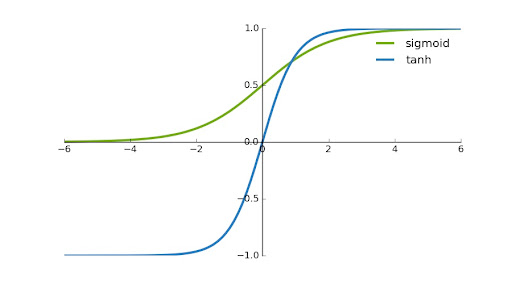

This is potentially due to our implementation of the networks' backpropagation. We specifically were training our networks to attempt to model the desired output of `0` or `1` based on the classification of the data. As you can see in the figure above, the sigmoid function has a range of `(0, 1)`, and there are an equal number of inputs that result in outputs close to `0` and close to `1`. On the other hand the hyperbolic tangent has a range of `(-1, 1)`, and our backpropagation algorithm does not make use of the negative range. Therefore our network utilizing the hyperbolic tangent is attempting the fit the outputs to `0` and `1` still, but it the required input to achieve a value close to `0` is much more constrained than the sigmoid function. Interestingly this fact seemed to increase performance on our validation sets, increasing generalization power, but greatly hindered the modeling power of the network. 

We found that the size of the hidden layer with the minimal error varies depending on the dataset split and initials weights.  For the sigmoid function, the errors for each size varies between any size and does not affect the minamal error and accuracy.  Similarly for the hyperbolic tangent function, the errors vary but the minimal error tends to be at a size of 3 or 4 units in the hidden layer.  This could be related to the discrepency between the accuracy for the two squashing functions tested.